In [1]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

In [2]:
class Policy(object):

    def __init__(self, env) -> None:
        self.env = env

    def action(self, q, index):
        """
        implement this function in the sub class
        """
        raise NotImplementedError()

    def average_performance(self, policy_fct, q):
    
        acc_returns = 0.
        n = 500
        for i in range(n):
            done, truncated = False, False
            s = self.env.reset()
            while not done and not truncated:
                a = policy_fct(q, s)
                s, reward, done, truncated, info = self.env.step(a)
                acc_returns += reward

        return acc_returns/n

class GreedyPolicy(Policy):

    def __init__(self, env):
        super().__init__(env)

    def action(self, q, s):
        return np.argmax(q[s])

class SoftmaxPolicy(Policy):
    
    def __init__(self, env, rng):
        super().__init__(env)
        self.rng = rng


    def action(self, q, s, T):
        probs = np.exp(q[s]/T) / np.sum(np.exp(q[s]/T))
        probs =  probs/ np.sum(probs) # Ensure probs is normalised to 1 (to avoid rounding errors)
        randchoice = self.rng.random()
        flag = 1; k = 1
        while flag:

            if randchoice<np.sum(probs[0:k]):
                action = k-1 # adjust for zero based action index
                flag = 0
            
            k = k + 1

        return action

    def get_action(self, T):     
        return lambda q,s: self.action(q, s, T=T)

In [3]:
# parameters for sarsa(lambda)
episodes = 5000
STEPS = 500
gamma = 0.9

alpha_critic = 0.02
alpha_actor = 0.02

epsilon_start = 1
epsilon_end = 0.2
epsilon_annealing_stop = int(episodes*0.7)

eligibility_decay = 0.3

In [4]:
desc = generate_random_map(size=16, p=1.0)
env = gym.make('FrozenLake-v1', is_slippery=False, new_step_api=True, desc=desc, max_episode_steps=STEPS)

print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

actionsDict = {}
actionsDict[0] = "  L  "
actionsDict[1] = "  D  "
actionsDict[2] = "  R  "
actionsDict[3] = "  U  "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

optimalPolicy = ["L/D/R","  U  ","  U  ","  U  ",
                 "  L  ","  -  "," L/R ","  -  ",
                 "  U  ","  D  ","  L  ","  -  ",
                 "  -  ","  R  ","  D  ","  !  "]
    
print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Action space =  Discrete(4)
Observation space =  Discrete(256)
Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  


In [5]:
env.reset()
# env.render()

0

In [6]:
# q = np.ones((env.observation_space.n, env.action_space.n))
# # Set q(terminal,*) equal to 0
# q[5,:] = 0.0
# q[7,:] = 0.0
# q[11,:] = 0.0
# q[12,:] = 0.0
# q[15,:] = 0.0
performance = np.zeros(episodes//STEPS) # np.ndarray(episodes//10)

critic = np.random.uniform(low=0.0, high=0.0000000009, size=(env.observation_space.n, env.action_space.n))
# critic = np.random.uniform(low=0.0, high=0.00000009, size=(env.observation_space.n, env.action_space.n))
# v = np.random.rand(env.observation_space.n, env.action_space.n)

actor = np.zeros((env.observation_space.n, env.action_space.n))
# actor = np.random.uniform(low=0.0, high=0.0009, size=(env.observation_space.n, env.action_space.n))

rng = np.random.default_rng() # random number generator
policy_softmax = SoftmaxPolicy(env, rng)
policy_greedy = GreedyPolicy(env)




In [7]:
for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E_actor = np.zeros((env.observation_space.n, env.action_space.n))
    E_critic = np.zeros((env.observation_space.n, env.action_space.n))
    
    state = env.reset()
    action = policy_softmax.action(actor, state, epsilon)
    # action = action_epsilon_greedy(actor, state, epsilon)

    while True:

        (new_state, reward, done, truncated, info) = env.step(action)
        
        new_action = policy_softmax.action(actor, new_state, epsilon)
        # new_action = action_epsilon_greedy(actor, new_state, epsilon)

        E_actor[state, action] = 1
        
        td_error = reward + gamma * critic[new_state, new_action] - critic[state, action]

        E_critic[state, action] = 1

        critic = critic + alpha_critic * td_error * E_critic
        E_critic = eligibility_decay * gamma * E_critic

        actor = actor + alpha_actor * td_error * E_actor 
        E_actor = eligibility_decay * gamma * E_actor
        
        state, action = new_state, new_action

        if done or truncated:

            # if done:
                # print("done in {} steps ({})".format(env._elapsed_steps, episode))

            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        # performance[episode//100] = average_performance(get_action_epsilon_greedy(epsilon), q=actor)
        performance[episode//STEPS] = policy_greedy.average_performance(policy_greedy.action, q=actor)

Text(0, 0.5, 'Average reward of an epoch')

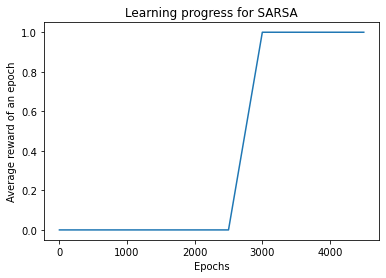

In [8]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [9]:
greedyPolicyAvgPerf = policy_greedy.average_performance(policy_greedy.action, q=actor)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 1.0


In [10]:
q = actor
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:4,:])
print("Second row")
print(q[4:8,:])
print("Third row")
print(q[8:12,:])
print("Fourth row")
print(q[12:16,:])

(A,S) Value function = (256, 4)
First row
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Second row
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Third row
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Fourth row
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [11]:
policyFound = [actionsDict[np.argmax(q[0,:])],actionsDict[np.argmax(q[1,:])],actionsDict[np.argmax(q[2,:])],actionsDict[np.argmax(q[3,:])],
               actionsDict[np.argmax(q[4,:])],actionsDict[np.argmax(q[5,:])],actionsDict[np.argmax(q[6,:])],actionsDict[np.argmax(q[6,:])],
               actionsDict[np.argmax(q[8,:])],actionsDict[np.argmax(q[9,:])],actionsDict[np.argmax(q[10,:])],actionsDict[np.argmax(q[11,:])],
               actionsDict[np.argmax(q[12,:])],actionsDict[np.argmax(q[13,:])],actionsDict[np.argmax(q[14,:])],"  !  "]
print("Greedy policy found:")
idxs = [0,4,8,12]
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3])

print(" ")

print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

env.close()

Greedy policy found:
  L     L     L     L  
  L     L     L     L  
  L     L     L     L  
  L     L     L     !  
 
Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  
